In [1]:
!pip install beautifulsoup4 requests
!pip install schedule

In [2]:
import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests
import pandas as pd
from time import sleep
import schedule
import pandas as pd
import re
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import spacy
import re

import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

In [3]:
n_top_words = 60 
pagesToGet= 1
upperframe=[]  
submeu_li = []

nlp=spacy.load('en_core_web_sm')
all_stopwords = nlp.Defaults.stop_words

In [4]:
def get_soup(url1):

  page=""
  #an exception might be thrown, so the code should be in a try-except block
  try:
      #use the browser to get the url. This is suspicious command that might blow up.
      page=requests.get(url1)                             # this might throw an exception if something goes wrong.

  except Exception as e:                                   # this describes what to do if an exception is thrown
      error_type, error_obj, error_info = sys.exc_info()      # get the exception information
      print ('ERROR FOR LINK:',url1)                          #print the link that cause the problem
      print (error_type, 'Line:', error_info.tb_lineno)     #print error info and line that threw the exception
  
  soup=BeautifulSoup(page.text,'html.parser')
  return soup

In [5]:
def get_news(): 
  url = "https://www.npr.org/sections/news/" 
  frame =[]
  soup = get_soup(url)
  links=soup.find_all(class_="item")
  
  for j in links:
    St = j.find("div",attrs={'class':'item-info'}).find("h2").text.strip()
    La = j.find("p").text.strip()
    if(len(La) > 10 and len(St) > 10):
      frame.append((St + " " +La))
    
  submeu=soup.find(class_="animated")#.find_all("li")

  for a in submeu.find_all('a', href=True):
    url = "https://www.npr.org" + a['href']
    soup = get_soup(url)
    links=soup.find_all(class_="item")
    for j in links:
      Statement = j.find("div",attrs={'class':'item-info'}).find("h2").text.strip()
      Label = j.find("p").text.strip()
      if(len(Label) > 10 and len(Statement) > 10):
        frame.append((Statement+ " " +Label))

  frame = [re.sub('\n','', f) for f in frame]
  frame = [re.sub(' +', ' ', f) for f in frame]
  frame = list(set(frame))

  return frame

In [6]:
def remove_mystopwords(sentence):
    tokens = sentence.split(" ")
    tokens_filtered= [word for word in tokens if not word in all_stopwords]
    return (" ").join(tokens_filtered)

In [7]:
def data_cleaning(frame):
  en_core = spacy.load('en_core_web_sm')
  #print("++++++++", frame)
  lemma_frame_ls = []
  frame = [f.lower() for f in frame]
  frame = [re.sub('hide caption','', word) for word in frame]
  frame = [re.sub('getty images','', word) for word in frame]
  frame = [re.sub('[^A-Za-z ]+', '', word) for word in frame]
  #print("--------------", frame)
  frame =[remove_mystopwords(text) for text in frame]
  #frame = ' '.join(frame)
  #print("===========", frame)
  #doc=nlp(frame)
  # Lemmatizing the text
  #lemma_frame = [token.lemma_ for token in doc]
  #lemma_frame_str = ' '.join(lemma_frame)

  #lemma_frame_ls.append(lemma_frame_str)
  frame = [re.sub(' +', ' ', word) for word in frame]

  df = pd.DataFrame(frame, columns=['data'])
  df["data_cleanned"] = df['data'].apply(lambda x: " ".join([y.lemma_ for y in en_core(x)]))

  return df

In [8]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

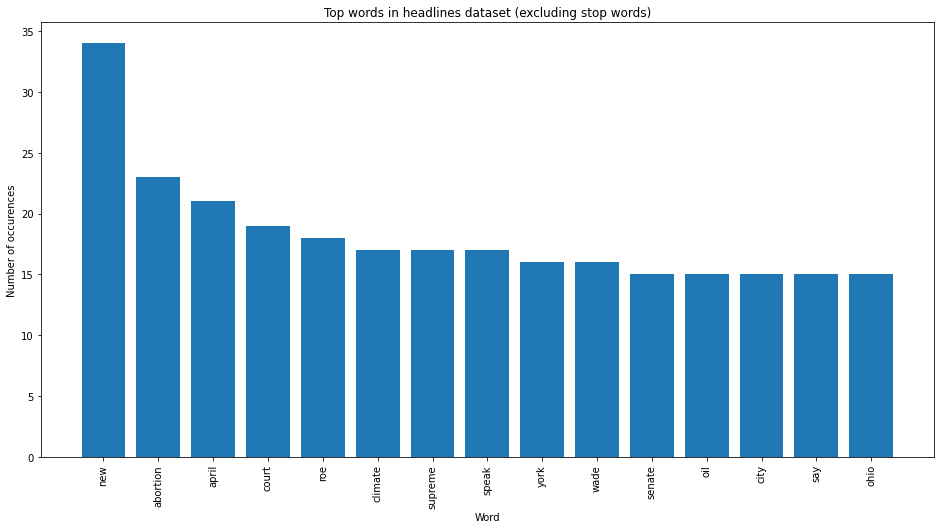

In [9]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

reindexed_data = data_cleaning(get_news())
reindexed_data = reindexed_data['data_cleanned']

count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [10]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [11]:
from textblob import TextBlob
import scipy.stats as stats
tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]

In [12]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Total number of words:  3971
Mean number of words per headline:  24.213414634146343


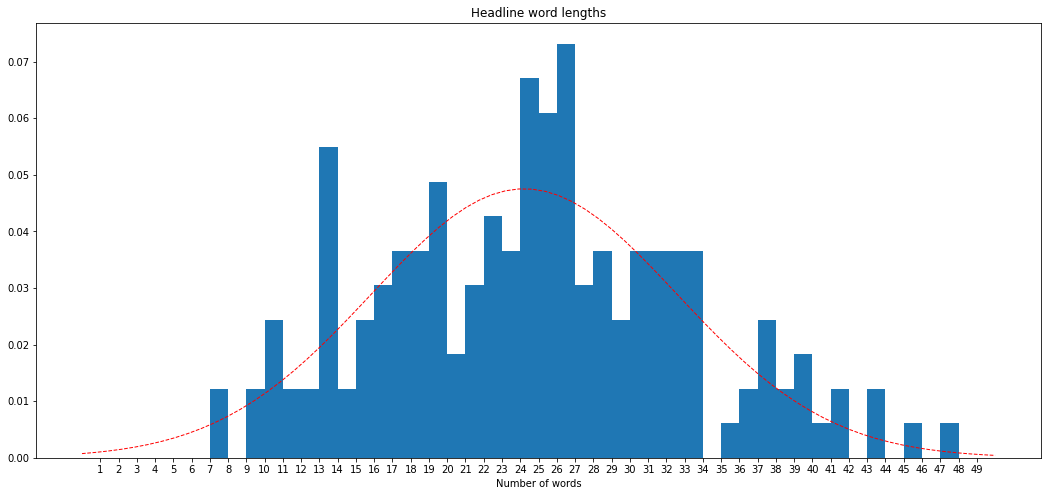

In [13]:
y = stats.norm.pdf(np.linspace(0,50,70), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,50), density=True);
ax.plot(np.linspace(0,50,70), y, 'r--', linewidth=1);
ax.set_title('Headline word lengths');
ax.set_xticks(range(1,50));
ax.set_xlabel('Number of words');
plt.show()

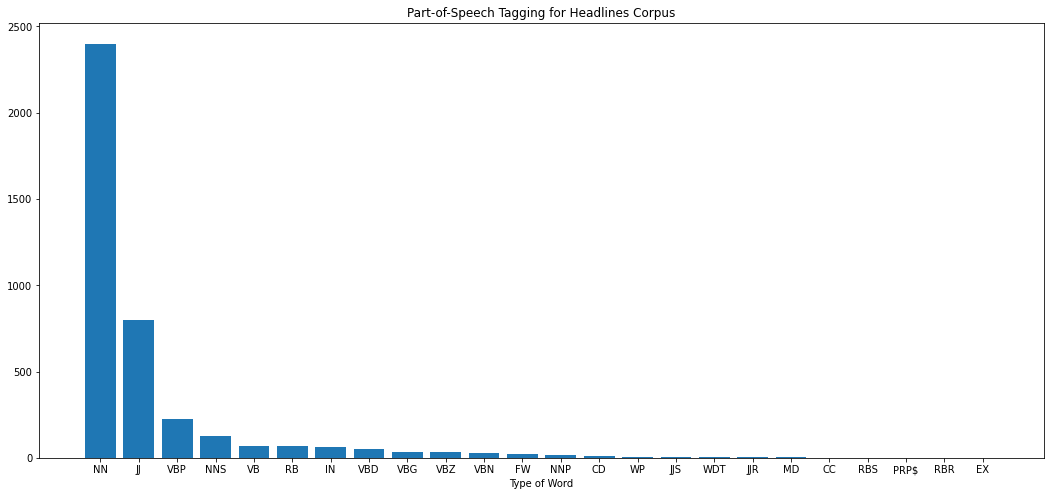

In [14]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for Headlines Corpus');
ax.set_xlabel('Type of Word');

In [15]:
count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
#small_text_sample = reindexed_data.sample(n=10000, random_state=0).values

print('Headline before vectorization: {}'.format(reindexed_data[123]))

document_term_matrix = count_vectorizer.fit_transform(reindexed_data)

print('Headline after vectorization: \n{}'.format(document_term_matrix[123]))

Headline before vectorization: complex effort hold vladimir putin accountable war crimes father oleksandr yarmolchyk stand inside demolish nave orthodox church peremoha ukraine april say russians bomb church hold franco ordoez npr
Headline after vectorization: 
  (0, 1555)	1
  (0, 1912)	1
  (0, 1847)	1
  (0, 90)	1
  (0, 541)	1
  (0, 856)	1
  (0, 800)	2
  (0, 1220)	1
  (0, 1680)	1
  (0, 299)	2
  (0, 349)	1
  (0, 1899)	1
  (0, 1405)	1
  (0, 13)	1
  (0, 394)	1
  (0, 626)	1
  (0, 1244)	1
  (0, 1964)	1
  (0, 448)	1
  (0, 1183)	1
  (0, 1254)	1
  (0, 1297)	1
  (0, 1539)	1
  (0, 182)	1
  (0, 683)	1
  (0, 1252)	1


In [16]:

n_topics = 20
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [17]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [18]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [19]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        if not isinstance(temp_vector_sum, int):
          temp_vector_sum = temp_vector_sum.toarray()
          top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
          top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [20]:
top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  roe supreme court
Topic 2:  new york city
Topic 3:  ohio primary senate
Topic 4:  oil russian mariupol
Topic 5:  grigsby makeup erika
Topic 6:  house secretary biden
Topic 7:  abortion speak dc
Topic 8:  climate change city
Topic 9:  dam water photo
Topic 10:  free turbotax settlement
Topic 11:  covid people kill
Topic 12:  shirt argentina wear
Topic 13:  health home mask
Topic 14:  nasa sample solar
Topic 15:  march place church
Topic 16:  hari kondabolu antoine
Topic 17:  scientist human emotion
Topic 18:  hospital capitol charge
Topic 19:  race tulsa npr
Topic 20:  texas say fossil


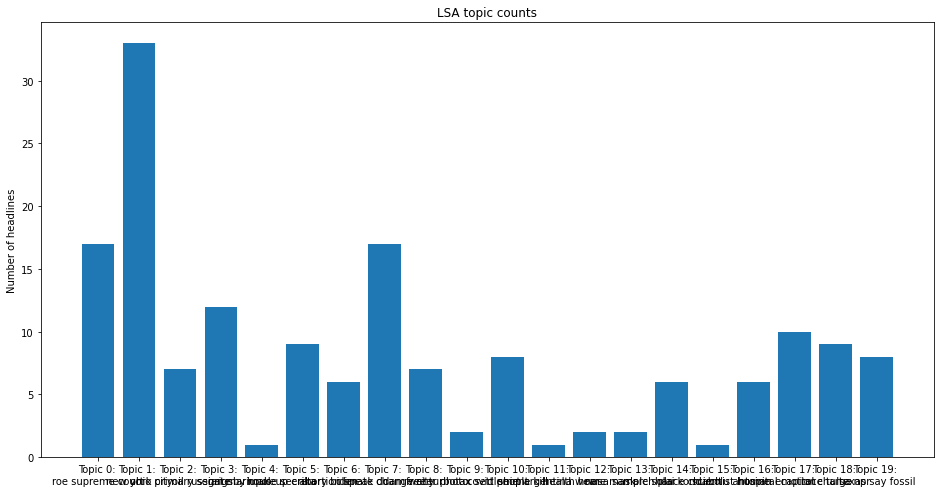

In [21]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.show()

In [22]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 164 samples in 0.001s...
[t-SNE] Computed neighbors for 164 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 164 / 164
[t-SNE] Mean sigma: 0.972190
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.659302
[t-SNE] KL divergence after 1250 iterations: 0.254558


In [23]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [24]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [25]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

In [26]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(document_term_matrix)

In [27]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [28]:
top_n_words_lda = get_top_n_words(3, lda_keys, document_term_matrix, count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  wave california chappelle
Topic 2:  zurich natural capitol
Topic 3:  house free solar
Topic 4:  secretary ukraine mariupol
Topic 5:  oil russian abortion
Topic 6:  gas stock city
Topic 7:  quantitative kasha kondabolu
Topic 8:  ohio primary senate
Topic 9:  new people die
Topic 10:  library rep book
Topic 11:  abortion john underground
Topic 12:  climate change emotion
Topic 13:  fairfax amber speak
Topic 14:  mariupol york new
Topic 15:  supreme court roe
Topic 16:  abortion mask washington
Topic 17:  south new health
Topic 18:  arizona judge year
Topic 19:  tulsa shirt auction
Topic 20:  church texas figure


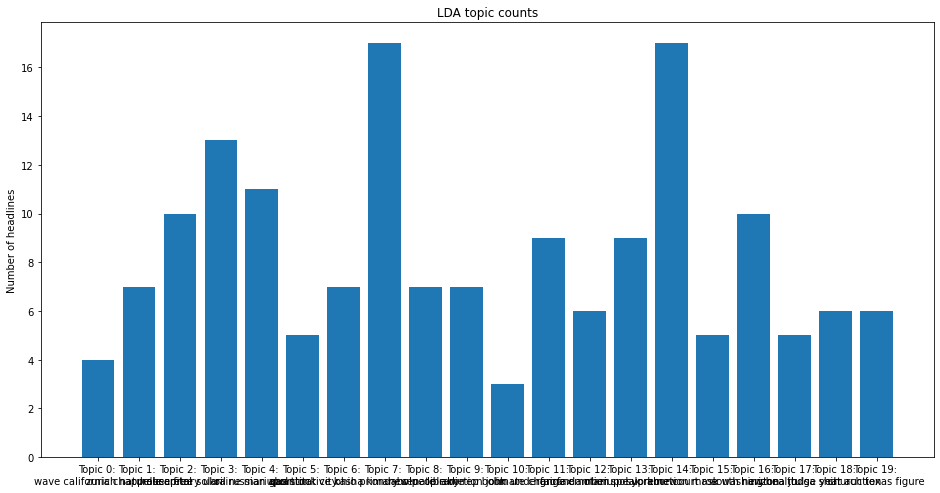

In [29]:
top_3_words = get_top_n_words(3, lda_keys, document_term_matrix, count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

In [30]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 164 samples in 0.000s...
[t-SNE] Computed neighbors for 164 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 164 / 164
[t-SNE] Mean sigma: 0.716834
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.686432
[t-SNE] KL divergence after 1200 iterations: 0.154748


In [31]:
top_3_words_lda = get_top_n_words(3, lda_keys, document_term_matrix, count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [32]:
for t in range(n_topics):
    print(top_3_words_lda[t])

wave california chappelle
zurich natural capitol
house free solar
secretary ukraine mariupol
oil russian abortion
gas stock city
quantitative kasha kondabolu
ohio primary senate
new people die
library rep book
abortion john underground
climate change emotion
fairfax amber speak
mariupol york new
supreme court roe
abortion mask washington
south new health
arizona judge year
tulsa shirt auction
church texas figure
